## Using Alphalens to evaluate the singals performance as an alpha factor

This part does an alphalens breakdown for the out of sample predictions we created

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os
import warnings
from pathlib import Path
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import pickle
from scipy.stats import spearmanr, pearsonr
import shap

from alphalens import plotting
from alphalens import performance as perf
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return, std_conversion
from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet,
                             create_information_tear_sheet)

idx = pd.IndexSlice

In [3]:
# Code is taken from alphalens module, needed to rearrange because of multiindex
# issues with newer versions of pandas.
from pandas.tseries.offsets import CustomBusinessDay, Day, BusinessDay # need import to run infer_trading_calendar


def infer_trading_calendar(factor_idx, prices_idx):
    """
    Infer the trading calendar from factor and price information.

    Parameters
    ----------
    factor_idx : pd.DatetimeIndex
        The factor datetimes for which we are computing the forward returns
    prices_idx : pd.DatetimeIndex
        The prices datetimes associated withthe factor data

    Returns
    -------
    calendar : pd.DateOffset
    """
    full_idx = factor_idx.union(prices_idx)

    traded_weekdays = []
    holidays = []

    days_of_the_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for day, day_str in enumerate(days_of_the_week):

        weekday_mask = (full_idx.dayofweek == day)

        # drop days of the week that are not traded at all
        if not weekday_mask.any():
            continue
        traded_weekdays.append(day_str)

        # look for holidays
        used_weekdays = full_idx[weekday_mask].normalize()
        all_weekdays = pd.date_range(full_idx.min(), full_idx.max(),
                                     freq=CustomBusinessDay(weekmask=day_str)
                                     ).normalize()
        _holidays = all_weekdays.difference(used_weekdays)
        _holidays = [timestamp.date() for timestamp in _holidays]
        holidays.extend(_holidays)

    traded_weekdays = ' '.join(traded_weekdays)
    return CustomBusinessDay(weekmask=traded_weekdays, holidays=holidays)

In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [5]:
sns.set_style('whitegrid')

In [6]:
YEAR = 252
idx = pd.IndexSlice

In [7]:
scope_params = ['lookahead', 'train_length', 'test_length']
daily_ic_metrics = ['daily_ic_mean', 'daily_ic_mean_n', 'daily_ic_median', 'daily_ic_median_n']
lgb_train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']

## Collect Data

In [8]:
def load_predictions(lookahead):
    predictions = (pd.read_hdf('data/predictions.h5', f'lgb/test/{lookahead:02}').drop('y_test', axis=1))
    predictions.sort_index(inplace=True)
    return predictions

In [9]:
# Will work if predictions have been generated using the different lookaheads, comment out others if data is not available
lookahead01 = load_predictions(1)
lookahead05 = load_predictions(5)
lookahead21 = load_predictions(21)

In [10]:
test_tickers = lookahead01.index.get_level_values('symbol').unique()

## AlphaLens Analysis - Validation Performance

#### Get Trade Prices

In [11]:
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = '/Users/Eric/Desktop/Model Creation/Gradient Boosters/data/prices' # h.5 file that was created in the end of 1_preparing_the_model_data
    prices = (pd.read_hdf(DATA_STORE, 'prices'))
    prices.index.names = ['symbol', 'date']
    return (prices.loc[idx[tickers, '2019': '2021'], 'open']
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [12]:
trade_prices = get_trade_prices(test_tickers)

UnsortedIndexError: 'MultiIndex slicing requires the index to be lexsorted: slicing on levels [1], lexsort depth 0'

In [ ]:
def factor_data_lookahead(lookaheadprediction):  
    factor = lookaheadprediction.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()
    factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
    factor_data.index.rename(['date','asset'], inplace=True)
    # Needed to set the freq. of the datetime index, and match formatting for Alphalens.
    # Workaround for the multiindex. 
    factor_dateindex = factor.index.levels[0]
    freq = infer_trading_calendar(factor_dateindex, trade_prices.index)
    factor_data = factor_data.unstack().asfreq(freq).stack()
    factor_data.index.names = ['date', 'asset']
    return factor_data

In [ ]:
fd01 = factor_data_lookahead(lookahead01)
fd05 = factor_data_lookahead(lookahead05)
fd21 = factor_data_lookahead(lookahead21)

Dropped 3.8% entries from factor data: 3.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 3.0% entries from factor data: 3.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


## Alpha Factor Performance

In [ ]:
def runall(factor_data,lookahead):
    mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,)
    
    factor_returns = perf.factor_returns(factor_data)

    mean_quant_ret, std_quantile = perf.mean_return_by_quantile(factor_data,
                                                            by_group=False,
                                                            demeaned=True)

    mean_quant_rateret = mean_quant_ret.apply(rate_of_return, axis=0,
                                          base_period=mean_quant_ret.columns[0])

    mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,)

    mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(
    rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],)

    compstd_quant_daily = std_quant_daily.apply(std_conversion,
                                            base_period=std_quant_daily.columns[0])

    alpha_beta = perf.factor_alpha_beta(factor_data,
                                    demeaned=True)
    
    mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(
    mean_quant_rateret_bydate,
    factor_data["factor_quantile"].max(),
    factor_data["factor_quantile"].min(),
    std_err=compstd_quant_daily,)

    print(mean_ret_spread_quant.mean().mul(10000).to_frame('Mean Period Wise Spread (bps)').join(alpha_beta.T).T)

    fig, axes = plt.subplots(ncols=3, figsize=(18, 4))

    plotting.plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])
    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)
    axes[0].set_xlabel('Quantile')

    plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate[f'{lookahead:01}D'],
                                             freq=pd.tseries.offsets.BDay(),
                                             period=f'{lookahead:01}D',
                                             ax=axes[1])
    axes[1].set_title(f'Cumulative Return by Quantile ({lookahead:01}D Period)')

    title = f"Cumulative Return - Factor-Weighted Long/Short PF ({lookahead:01}D Period)"
    plotting.plot_cumulative_returns(factor_returns[f'{lookahead:01}D'],
                                 period=f'{lookahead:01}D',
                                 freq=pd.tseries.offsets.BDay(),
                                 title=title,
                                 ax=axes[2])

    fig.suptitle('Alphalens - Validation Set Performance', fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=.85);

                                      1D         5D        10D        21D
Mean Period Wise Spread (bps)  15.424191  13.740053  10.801099  10.617497
Ann. alpha                      0.230169   0.172065   0.145709   0.137879
beta                            0.084895   0.141313   0.081975   0.088020


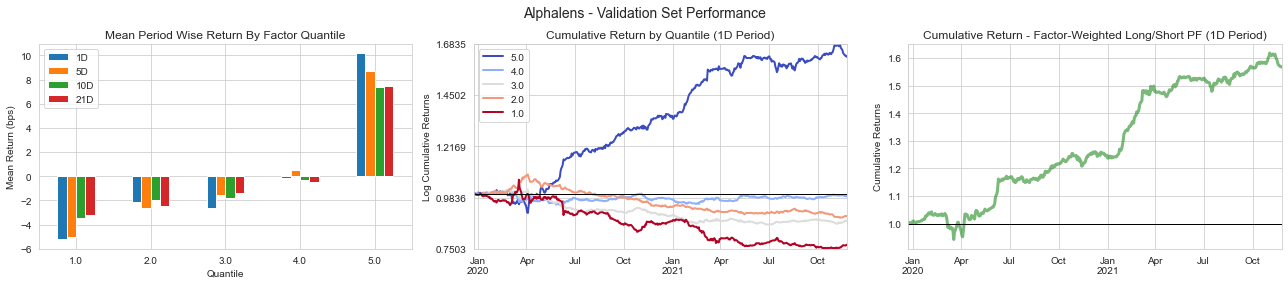

In [ ]:
runall(fd01,1)

                                      1D         5D        10D        21D
Mean Period Wise Spread (bps)  16.516009  16.834476  16.567923  17.877625
Ann. alpha                      0.313393   0.293411   0.262676   0.264996
beta                           -0.015144  -0.010944   0.050177   0.115106


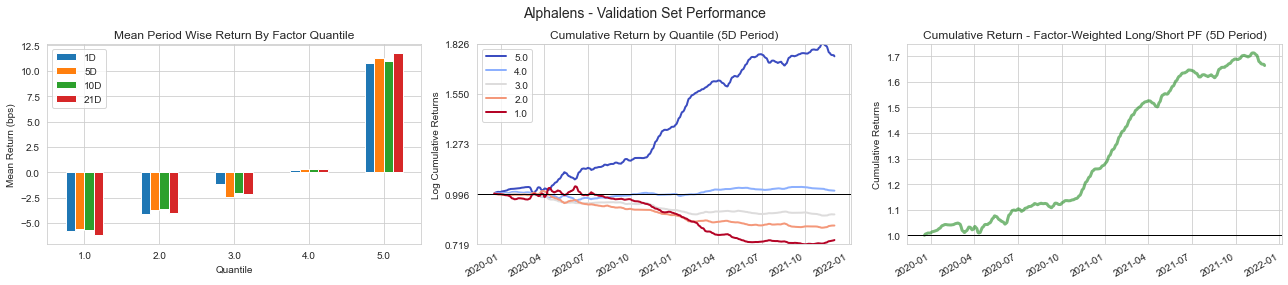

In [ ]:
runall(fd05,5)

                                      1D         5D        10D        21D
Mean Period Wise Spread (bps)  18.341136  18.835348  15.714866  15.210218
Ann. alpha                      0.239536   0.252723   0.243373   0.226541
beta                            0.174593   0.159812   0.098636   0.144307


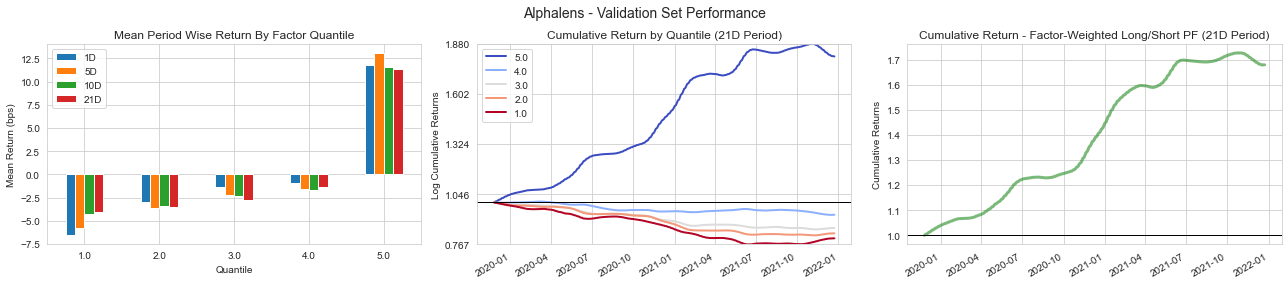

In [ ]:
runall(fd21,21)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.432295,0.117307,-0.030769,0.058862,92909,20.021075
2.0,-0.262669,0.142057,-0.019668,0.053281,92908,20.020860
3.0,-0.206595,0.157941,-0.014371,0.050984,92422,19.916131
4.0,-0.170857,0.173523,-0.008882,0.049072,92908,20.020860
5.0,-0.134960,0.261509,0.004640,0.048439,92909,20.021075


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.313,0.293,0.263,0.265
beta,-0.015,-0.011,0.050,0.115
Mean Period Wise Return Top Quantile (bps),10.762,11.282,10.937,11.759
Mean Period Wise Return Bottom Quantile (bps),-5.754,-5.549,-5.700,-6.208
Mean Period Wise Spread (bps),16.516,16.834,16.568,17.878


Information Analysis


,1D,5D,10D,21D
IC Mean,0.012,0.029,0.036,0.060
IC Std.,0.142,0.139,0.140,0.142
Risk-Adjusted IC,0.083,0.211,0.260,0.421
t-stat(IC),NaN,4.661,5.740,9.302
p-value(IC),NaN,0.000,0.000,0.000
IC Skew,NaN,-0.157,-0.255,-0.076
IC Kurtosis,NaN,0.905,0.608,0.335


Turnover Analysis


,10D,1D,21D,5D
Quantile 1 Mean Turnover,0.607,0.334,0.678,0.513
Quantile 2 Mean Turnover,0.730,0.579,0.751,0.695
Quantile 3 Mean Turnover,0.751,0.620,0.766,0.721
Quantile 4 Mean Turnover,0.727,0.558,0.752,0.683
Quantile 5 Mean Turnover,0.509,0.288,0.567,0.434


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.791,0.56,0.419,0.304


<Figure size 432x288 with 0 Axes>

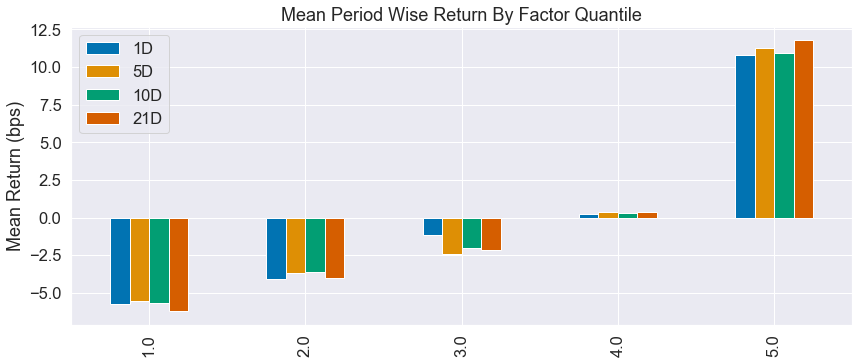

In [ ]:
create_summary_tear_sheet(fd05)

In [ ]:
create_full_tear_sheet(fd05)

## Using SHAP Values to Understand how the model is making its predictions

In [ ]:
# Change values here to choose which trained model you want to asess the signal from
# Predictions were generated form 2020-11-26 to 2021-11-26. So, each fold is around 3 months. So, this lgbmodel was generated and predicted the months 1-3 of the second year of the test, using the parameters 
# from the highest performing set of CV parameters.

lookahead = 21
model=0
fold=1

In [ ]:
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')
data = pd.read_hdf('data.h5', 'model_data').sort_index()
data = data.loc[idx[:, '2019':'2021'], :]
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist()

In [ ]:
def get_lgb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + lgb_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    print(df.loc[param_cols])

def modelforfold(lookahead,modelnum,fold):
    results_path = Path('TrainedModels', f'{lookahead:02}')
    get_lgb_params(lgb_daily_ic,t=lookahead,best=modelnum)
    lgbmodel = pickle.load(open(f'TrainedModels/21/model_{modelnum:02}_{fold:02}.pkl', 'rb'))
    return lgbmodel

In [ ]:
lgbmodel = modelforfold(lookahead,model,fold)

train_length        1138.00
test_length           63.00
learning_rate          0.01
num_leaves           128.00
feature_fraction       0.95
min_data_in_leaf     500.00
boost_rounds         500.00
Name: 3729, dtype: float64


In [ ]:
def get_feature_importance(model, importance_type='split'):
    fi = pd.Series(model.feature_importance(importance_type=importance_type), 
                   index=model.feature_name())
    return fi/fi.sum()

In [ ]:
feature_importance = (get_feature_importance(lgbmodel).to_frame('Split').
                      join(get_feature_importance(lgbmodel, 'gain').to_frame('Gain')))

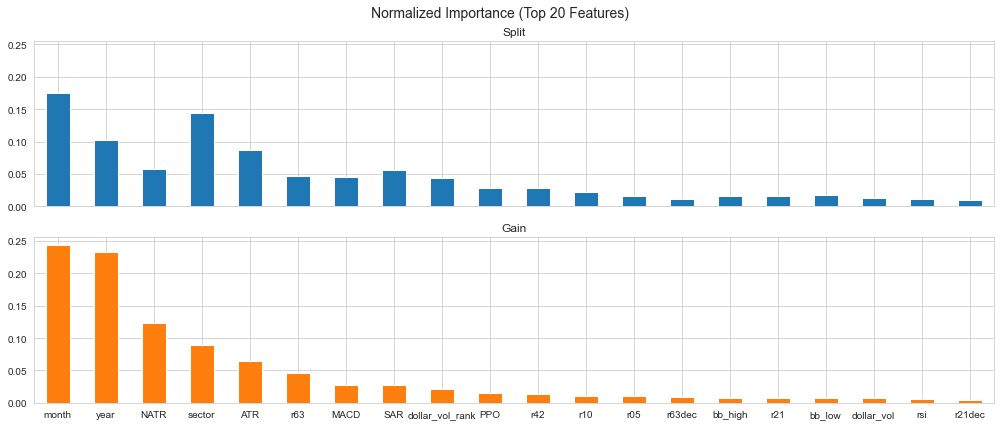

In [ ]:
#Show feature importance for the selected model
(feature_importance
 .nlargest(20, columns='Gain')
 .sort_values('Gain', ascending=False)
 .plot
 .bar(subplots=True,
      layout=(2, 1),
      figsize=(14, 6),
      legend=False,
      sharey=True,
      rot=0))
plt.suptitle('Normalized Importance (Top 20 Features)', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.9);

In [ ]:
# So, lets say we want to assess a predictions from this model. Lets take a look at the predictions from the month of November 4th in 2020. 
decfactors = fd21.loc['2020-11-4']
decfactors.sort_values(by='factor',ascending=False)
# Using this, we can see the model predicted high returns on the FLWS ticker, which we might want to dig into why this was the case. 

1D        5D       10D       21D  \
date                      asset                                           
2020-11-04 00:00:00+00:00 NOG    0.078652  0.179775  0.471910  0.957865   
                          MDXG  -0.035714 -0.174286 -0.042857 -0.071429   
                          ENDP  -0.010163  0.010163  0.069106  0.115854   
                          CLDX   0.000000  0.095633  0.095633  0.088999   
                          RIOT   0.000000 -0.020997  0.433071  1.477690   
...                                   ...       ...       ...       ...   
                          AIV   -0.008983  0.128433  0.164742  0.261479   
                          SFL    0.024691  0.095679  0.055556  0.029321   
                          DENN   0.031746  0.210884  0.233560  0.523810   
                          CNX    0.007883  0.096847  0.047297  0.031532   
                          FRO    0.005338  0.137011  0.188612  0.151246   

                                   factor  factor_quantile  
date                      asset                             
2020-11-04 00:00:00+00:00 NOG    0.194088              5.0  
                          MDXG   0.138283              5.0  
                          ENDP   0.090953              5.0  
                          CLDX   0.090315              5.0  
                          RIOT   0.072007              5.0  
...                                   ...              ...  
                          AIV   -0.166016              1.0  
                          SFL   -0.167398              1.0  
                          DENN  -0.179045              1.0  
                          CNX   -0.182240              1.0  
                          FRO   -0.190560              1.0  

[949 rows x 6 columns]

In [ ]:
# Show the average 21 day return for objects in the factor quanitle 5 basket, with the avearge 21 day return of our universe subtracted from it. 
decfac5 = decfactors.loc[decfactors['factor_quantile'] == 5.0] 
decfac5['21D'].mean() - decfactors['21D'].mean()

0.07364469450189703

In [ ]:
# Show the 8 different models and the singals that they produced for the selected stock
lookahead21.loc[idx['NOG','2020-11-23':'2020-11-23'],:]

,,0,1,2,3,4,5,6,7,8,9
symbol,date,,,,,,,,,,
NOG,2020-11-23,-0.196551,-0.200079,-0.049838,-0.035175,-0.019461,-0.035568,-0.002337,-0.192998,-0.202385,-0.201454


In [ ]:
shap.initjs()
X = data[features].loc[idx['NOG','2020-11-04':'2020-11-04'],:]
# single_shap_explained('FLWS','2020-12-14')
explainer = shap.TreeExplainer(lgbmodel)
shap_values = explainer.shap_values(X=X)
shap.force_plot(explainer.expected_value, shap_values, X)
# Will not excatly match the prediction output, but should provide an idea of what is pushing the model to predict higher or lower returns

In [ ]:
# Show the shap breakdowns for the 5th factor quantile
uniques = decfac5.index.get_level_values(1).unique() # Get list of tickers in the 5th quantile
X = data[features].loc[idx[uniques,'2020-11-04':'2020-11-04'],:]
explainer = shap.TreeExplainer(lgbmodel)
shap_values = explainer.shap_values(X=X)
shap.summary_plot(shap_values, X, show=False)
plt.tight_layout();
# Will not excatly match the prediction output, but should provide an idea of what is pushing the model to predict higher or lower returns